In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.plotting import lag_plot

[*********************100%***********************]  1 of 1 completed


TypeError: can only concatenate str (not "list") to str

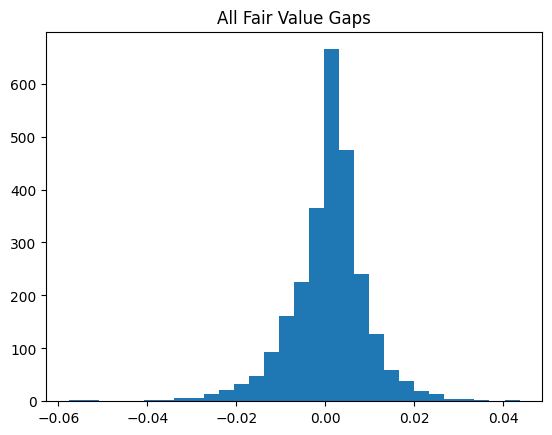

In [ ]:
TICKER = 'SPY'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

SHIFT = 1
STRATEGY = 'Both_FVG'

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

# define the target variable (also called dependent variable, or y)
def add_target(df, shift=SHIFT):

    # what is the close price SHIFT days from now?
    df[f'Close + {shift}'] = df['Close'].shift(-shift)

    # what is the change in close price SHIFT days from now?
    df[f'{shift} Period % Change'] = (df[f'Close + {shift}'] - df['Close']) / df['Close']

    return df

def bull_fvg(df):

    df['High_2prev'] = df['High'].shift(2)
    df['Bull_FVG'] = (df['Low'] > df['High_2prev']).astype(int)
    df['Bull_FVG_Val'] = (df['Low'] - df['High_2prev']) * df['Bull_FVG'] / df['Close']

    return df

def bear_fvg(df):

    df['Low_2prev'] = df['Low'].shift(2)
    df['Bear_FVG'] = (df['High'] < df['Low_2prev']).astype(int)
    df['Bear_FVG_Val'] = (df['High'] - df['Low_2prev']) * df['Bear_FVG'] / df['Close']

    return df

def prepare_dataframe_for_regression(df):
    df = df[(df['Bull_FVG'] == 1) | (df['Bear_FVG'] == 1)].copy()
    df['Both_FVG'] = df['Bear_FVG_Val'] + df['Bull_FVG_Val']

    plt.figure()
    plt.hist(df['Both_FVG'], bins=30)
    plt.title('All Fair Value Gaps')

    return df

def generate_regression_output(df, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change'):
    subset = df[[features, target]].dropna()

    X = subset[features]
    y = subset[target]

    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()

    intercept = model.params['const']
    coefficient = model.params[features]
    r2 = model.rsquared
    p_value = model.pvalues[features]
    n_obs = len(subset)

    y_pred = model.predict(X_with_const)

    # Console summary
    print(model.summary())
    print(f"\n[Regression Summary]")
    print(f"Observations: {n_obs}")
    print(f"Coefficient: {coefficient:.6f}")
    print(f"Intercept: {intercept:.6f}")
    print(f"R²: {r2:.6f}")
    print(f"P-Value: {p_value:.6f}")

    # Plot
    plt.figure()
    plt.title(f'The Relationship Between {features} and {target}')
    plt.plot(X, y_pred, color='red', label=f'y = {coefficient:.2f}x + {intercept:.2f}')
    plt.scatter(X, y, alpha=0.6)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
    plt.legend()
    plt.grid(True)

    return df, intercept, coefficient

def validate_regression_output(df, coef, intercept):

    # information necessary
    df['Predictions'] = coef * df[f'{STRATEGY}'] + intercept
    df['Residuals'] = df[f'{SHIFT} Period % Change'] - df['Predictions'] 

    # plot for linearity/homoscedasticity
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    plt.title('Relationship Between Residuals and Predicted Values \n ' \
        'Curve Shape = Non-Linear Relationship - x \n ' \
        'Fanning = Heteroscedastic - x')
    
    # plot for autocorrelations
    plt.figure()
    lag_plot(df['Residuals'].dropna())
    plt.title('Lag Plot of Residuals \n Obvoius Relationship = Autocorrellation - x')

    # plot for normality
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('Distribution of Residuals \n Skew = Non-Normal - x')

    return df

def assess_regression_output(df, coef, features=f'{STRATEGY}', target=f'{SHIFT} Period % Change', n=100000):
    subset = df[[features, target]].dropna()
    X = subset[features]
    y = subset[target]

    real_r = np.corrcoef(X, y)[0, 1]
    correlations = []

    for _ in range(n):
        shuffled_y = np.random.permutation(y)
        r = np.corrcoef(X, shuffled_y)[0, 1]
        correlations.append(r)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.hist(correlations, bins=100, alpha=0.7, color='skyblue', label='Shuffled Correlations')
    plt.axvline(real_r, color='red', linestyle='--', label=f'Real Correlation = {real_r:.4f}')
    plt.title('Null Distribution of Correlation (Shuffled Targets)')
    plt.xlabel('Correlation Coefficient (r)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    return df

def main():
    df = get_data()
    df = add_target(df)
    df = bull_fvg(df)
    df = bear_fvg(df)
    df = prepare_dataframe_for_regression(df)
    df, fit_intercept, fit_coefficient = generate_regression_output(df)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept)
    df = assess_regression_output(df, coef=fit_coefficient)

    return df

df = main()
df